**Approach - <br>- Data Reading and Understanding<br>- Preprocessing => removal of punctuations, numbers, lemmatization, converting emoticons and emoji's to their language representation<br> - Count vectorizer/TF-IDF vectorizer<br>- Models => LogisticRegression, Multinomial NB, Complement NB**

In [1]:
#All imports

from helpers import preprocessing
from helpers import models

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nehkumar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nehkumar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nehkumar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\nehkumar\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [20]:
#reload if dependent module has changed
import importlib
importlib.reload(preprocessing)
importlib.reload(models)

### Step 1 - Data Reading and Understanding

In [4]:
comments_df = pd.read_excel('./data/comments.xlsx', usecols=['comment','Sentiment' ])
comments_df.head()

,comment,Sentiment
0,hashtag hashtag hashtag hashtag hashtag hashta...,Neutral
1,send it pic _x000D_\n👁_x000D_\n👉 user,Neutral
2,if i get it on time maybe 😢,Mixed
3,gorgeous ❤,Positive
4,😍😍😍😍,Positive


In [5]:
comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11856 entries, 0 to 11855
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   comment    11856 non-null  object
 1   Sentiment  11856 non-null  object
dtypes: object(2)
memory usage: 185.4+ KB


In [6]:
comments_df['Sentiment'].value_counts(normalize=True)

Positive    0.813850
Neutral     0.127783
Negative    0.052800
Mixed       0.005567
Name: Sentiment, dtype: float64

### Step 2 - Data Preparation

In [7]:
#Uses preprocessing module to perform clean up and data preparation
def prepare_data(df, is_train):
  processed_df = preprocessing.preprocess_data(df, 'comment')
  processed_df = preprocessing.remove_stopwords(processed_df, 'spelling_corrected', True)
  processed_df = preprocessing.lemmatization(processed_df, 'stopwords_removed')
  processed_df = preprocessing.convert_emoji(processed_df, 'lemma_comment')
  processed_df = preprocessing.convert_emoticon(processed_df, 'emoji_converted', True)
  processed_df['cleaned_comment'] = processed_df['emoticon_converted']

  if is_train:
    processed_df['target'] = processed_df['Sentiment'].map({"Neutral":0, "Positive":1, "Negative":2, "Mixed":3})

  return processed_df

In [8]:
train_processed_df = prepare_data(comments_df, True)
train_processed_df[['comment', 'cleaned_comment', 'target']].head()

,comment,cleaned_comment,target
0,hashtag hashtag hashtag hashtag hashtag hashta...,"[hashtag, hashtag, hashtag, hashtag, hashtag, ...",0
1,send it pic _x000d_\n👁_x000d_\n👉 user,"[send, picture, eye, backhand_index_pointing_r...",0
2,if i get it on time maybe 😢,"[get, time, maybe, crying_face]",3
3,gorgeous ❤,"[gorgeous, red_heart]",1
4,😍😍😍😍,"[smiling_face_with_heart-eyes, smiling_face_wi...",1


**Train Val split**

In [10]:
#90-10 split for train and val
X = train_processed_df['cleaned_comment']
y = train_processed_df['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify = y, train_size=0.9, random_state=100)

**Bag Of Words**

In [11]:
#tokenization is explicitly set to nothing as it has already been taken care off as part of preprocessing
def do_nothing_tokenizer(tokens):
  return tokens

In [16]:
count_vectorizer = CountVectorizer(tokenizer=do_nothing_tokenizer, preprocessor=None, lowercase=False)

#constructing a pipeline to perform grid search for hyper-parameter tuning
pipeline_elements = [('vect', count_vectorizer)]
hyper_params = {'vect__ngram_range': [(1, 1), (1, 2), (2, 2)]}

**TF-IDF**

In [13]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=do_nothing_tokenizer, preprocessor=None, lowercase=False)
pipeline_elements = [('vect', tfidf_vectorizer)]   
hyper_params = {'vect__max_df': (0.25, 0.5, 0.75), 'vect__ngram_range': [(1, 1), (1, 2), (2, 2)]}

### Step 3 - Model Building

**Logistic Regression**

In [ ]:
#models execution is driven through a helper module "models"
grid_model = models.logistic_regression_grid(pipeline_elements, hyper_params, X_train, y_train)
grid_results = pd.DataFrame({'C':grid_model.cv_results_.get('param_model__C').data, 
                             'param_vect__ngram_range':grid_model.cv_results_.get('param_vect__ngram_range').data,
                             'param_vect__max_df':grid_model.cv_results_.get('param_vect__max_df').data,
                             'mean_train_score':grid_model.cv_results_.get('mean_train_score'),
                             'mean_test_score':grid_model.cv_results_.get('mean_test_score')})

#fetch grid results to determine parameter combination and train and test score to avoid over-fitting
grid_results.to_csv('./grid_results.csv', index=False)

Fitting 15 folds for each of 108 candidates, totalling 1620 fits
train F1 Score: 0.9928243982257667


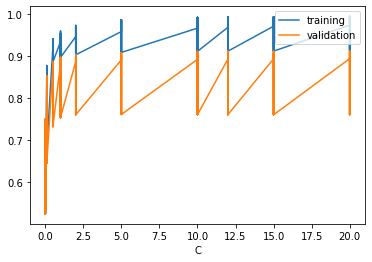

In [ ]:
plt.xlabel("C")
plt.plot(grid_results['C'], grid_results['mean_train_score'], label='training')
plt.plot(grid_results['C'], grid_results['mean_test_score'], label='validation')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#Training X_train on selected hyper param
final_vec = TfidfVectorizer(tokenizer=do_nothing_tokenizer, preprocessor=None, lowercase=False, max_df=0.5, ngram_range=(1,1))
final_pipeline_elements = [('vect', final_vec)]
final_model_params = {'C':1}
final_model = models.logistic_regression_pipeline(final_pipeline_elements, final_model_params, X_train, y_train)

#evaluate on val
models.evaluate(final_model, X_val, y_val, "val")

train F1 Score: 0.9246983446873855
val F1 Score: 0.892515511709761


**Multinomial Naive Bayes**

In [ ]:
grid_model = models.multinomial_naivebayes_grid(pipeline_elements, hyper_params, X_train, y_train)

Fitting 15 folds for each of 45 candidates, totalling 675 fits
train F1 Score: 0.984644232446532


In [ ]:
grid_results = pd.DataFrame({'alpha':grid_model.cv_results_.get('param_model__alpha').data, 
                             'param_vect__ngram_range':grid_model.cv_results_.get('param_vect__ngram_range').data,
                             'param_vect__max_df':grid_model.cv_results_.get('param_vect__max_df').data,                             
                             'mean_train_score':grid_model.cv_results_.get('mean_train_score'),
                             'mean_test_score':grid_model.cv_results_.get('mean_test_score')})
grid_results.to_csv('./grid_results.csv', index=False)

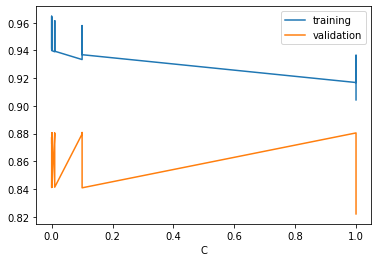

In [ ]:
plt.xlabel("C")
plt.plot(grid_results['alpha'], grid_results['mean_train_score'], label='training')
plt.plot(grid_results['alpha'], grid_results['mean_test_score'], label='validation')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#Training X_train on selected hyper param
final_vec = TfidfVectorizer(tokenizer=do_nothing_tokenizer, preprocessor=None, lowercase=False, max_df=0.5, ngram_range=(1,2))
final_pipeline_elements = [('vect', final_vec)]
final_model_params = {'alpha':1}
final_model = models.multinomial_naivebayes_pipeline(final_pipeline_elements, final_model_params, X_train, y_train)

#evaluate on val
models.evaluate(final_model, X_val, y_val, "val")

train F1 Score: 0.8666534559071031
val F1 Score: 0.844405819548204


**Complement Naive Bayes**

In [ ]:
grid_model = models.complement_naivebayes_grid(pipeline_elements, hyper_params, X_train, y_train)

Fitting 15 folds for each of 90 candidates, totalling 1350 fits
train F1 Score: 0.9693456483993078


In [ ]:
grid_results = pd.DataFrame({'alpha':grid_model.cv_results_.get('param_model__alpha').data,
                             'norm':grid_model.cv_results_.get('param_model__norm').data,
                             'param_vect__ngram_range':grid_model.cv_results_.get('param_vect__ngram_range').data,
                             'param_vect__max_df':grid_model.cv_results_.get('param_vect__max_df').data,
                             'mean_train_score':grid_model.cv_results_.get('mean_train_score'),
                             'mean_test_score':grid_model.cv_results_.get('mean_test_score')})
grid_results.to_csv('./grid_results.csv', index=False)

In [ ]:
#Training X_train on selected hyper param
final_vec = TfidfVectorizer(tokenizer=do_nothing_tokenizer, preprocessor=None, lowercase=False, max_df=0.5, ngram_range=(1,1))
final_pipeline_elements = [('vect', final_vec)]
final_model_params = {'alpha':1, 'norm':True}
final_model = models.complement_naivebayes_pipeline(final_pipeline_elements, final_model_params, X_train, y_train)

#evaluate on val
models.evaluate(final_model, X_val, y_val, "val")

train F1 Score: 0.949460086647319
val F1 Score: 0.9208717422988981


### Step 4 - Test Prediction

In [18]:
#fetch test data for predictions
test_df  = pd.read_excel('./data/Test.xlsx')
test_df.head()

,id,comment
0,1,ouuuu 😍😍
1,2,i copped sidechick and hustle baby 2.0
2,3,i have mask acne and acne scars with a normal ...
3,4,i'm disappointed that your brand is promoting...
4,5,😢 what a waste of products😢 but genuine art ❤


In [19]:
#perform same clean-up as train data
test_processed_df = prepare_data(test_df, False)
test_processed_df[['id','comment','cleaned_comment']].head()

,id,comment,cleaned_comment
0,1,ouuuu 😍😍,"[wow, smiling_face_with_heart-eyes, smiling_fa..."
1,2,i copped sidechick and hustle baby 2.0,"[copped, sidekick, hustle, baby]"
2,3,i have mask acne and acne scars with a normal ...,"[mask, acne, acne, scar, normal, skin, type, w..."
3,4,i'm disappointed that your brand is promoting...,"[disappointed, brand, promote, nonsense, funny..."
4,5,😢 what a waste of products😢 but genuine art ❤,"[crying_face, waste, product, crying_face, gen..."


In [ ]:
X_test = test_processed_df['cleaned_comment']
y_test_pred = final_model.predict(X_test)

print(y_test_pred)

[1 0 1 2 1]


In [ ]:
y_test_pred_proba = final_model.predict_proba(X_test)

In [ ]:
print(y_test_pred_proba)

array([[0.00224505, 0.99403352, 0.00173573, 0.0019857 ],
       [0.65314807, 0.19009375, 0.11206634, 0.04469184],
       [0.16379152, 0.38643835, 0.42076784, 0.02900229],
       [0.04745754, 0.02170055, 0.90883504, 0.02200687],
       [0.00758248, 0.0175906 , 0.08669329, 0.88813362]])